In [1]:
from sklearn.datasets import make_circles, make_moons
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def prepare_data(func):
    X, Y = func(n_samples=1000, noise=0.2, random_state=0)
    tl = int(len(X) * 0.8)
    return X[:tl], X[tl:], Y[:tl], Y[tl:]

def plot_data(X_test, Y_test, Y_pred):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
    sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=Y_test, ax=ax1)
    ax1.set_title("Actual labels")
    sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=Y_pred, ax=ax2)
    ax2.set_title("Predicted labels")
    plt.tight_layout()
    plt.show()

# Decision Trees

## What are the advantages and disadvantages of decision trees?

Advantages:
- inexpensive to construct
- extremely fast at classifying unknown records
- easy to interpret for small-sized trees
- can easily handle redundant or irrelevant attributes (unless the attributes are interacting)

Disadvantages:
- space of possible decision trees is exponentially large
- greedy approaches are often unable to find the best tree
- does not take into account interactions between attributes
- each decision boundary involves only a single attribute

## How do you build a decision tree model?

To build a decision tree model:
1. Choose a splitting criterion (e.g., information gain, Gini impurity).
2. Select the best attribute to split on based on the splitting criterion.
3. Recursively apply steps 1 and 2 to each child node until a stopping criterion is met.
4. Assign a class label to each leaf node based on the majority class of the training instances in that node.

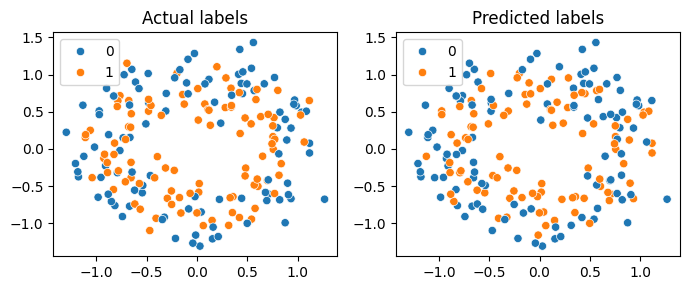

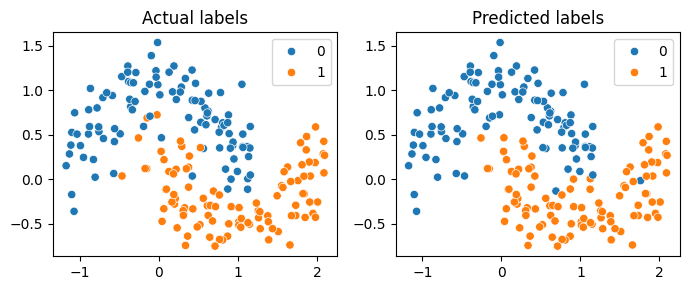

In [2]:
from sklearn.tree import DecisionTreeClassifier

def decision_boundary(func):
    X, Y = func(n_samples=1000, noise=0.2, random_state=0)
    tl = int(len(X) * 0.8)
    X_train, X_test, Y_train, Y_test = X[:tl], X[tl:], Y[:tl], Y[tl:]
    clf = DecisionTreeClassifier(
        criterion="gini",
        splitter="best",
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0,
        min_impurity_decrease=0,
    )

    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    plot_data(X_test, Y_test, Y_pred)

decision_boundary(make_circles)
decision_boundary(make_moons)

## What are the differences between classification and regression trees?

Classification trees are used when the target variable is categorical, while regression trees are used when the target variable is continuous. The splitting criterion for classification trees is typically based on impurity measures such as entropy or Gini index, while regression trees use variance reduction.

## What are impurity measures in decision trees?

Impurity measures are used to determine the best split at each node in a decision tree. The impurity of a node is a measure of how mixed the classes are in the node. Common impurity measures include entropy, Gini index, and misclassification error.

$$ \text{Entropy}(t) = -\sum_{c=1}^{C} p(c|t) \log_2(p(c|t)) $$

$$0 \leq \text{Entropy}(t) \leq 1$$

$$ \text{Gini}(t) = 1 - \sum_{c=1}^{C} [p(c|t)]^2 $$

$$0 \leq \text{Gini}(t) \leq 0.5$$

$$ \text{Misclassification error}(t) = 1 - \max_c[p(c|t)] $$

$$0 \leq \text{Misclassification error}(t) \leq 1$$

Where $t$ is the current node, $C$ is the number of classes, and $p(c|t)$ is the proportion of the samples that belong to class $c$ at node $t$. The impurity measure is used to calculate the information gain or Gini gain for each split.

### How do you use information gain to decide split?
1. Calculate the entropy of the target. $$ \text{Entropy}(S) = - \sum_{i=1}^n p_i \log_2 p_i $$
2. Calculate the entropy of the target for each feature. $$ \text{Entropy}(S, A) = \sum_{i=1}^n \frac{|S_i|}{|S|} \text{Entropy}(S_i) $$ where $S_i$ is the subset of $S$ for which feature $A$ has value $i$. $$ \text{Entropy}(S_i) = - \sum_{i=1}^n p_i \log_2 p_i $$
3. Calculate the information gain for each feature. $$ \text{Information Gain}(S, A) = \text{Entropy}(S) - \text{Entropy}(S, A) $$
4. Choose the feature with the highest information gain.

### How do you use Gini index to decide split?
1. Calculate the Gini index of the target. $$ \text{Gini}(S) = 1 - \sum_{i=1}^n p_i^2 $$
2. Calculate the Gini index of the target for each feature. $$ \text{Gini}(S, A) = \sum_{i=1}^n \frac{|S_i|}{|S|} \text{Gini}(S_i) $$ where $S_i$ is the subset of $S$ for which feature $A$ has value $i$. $$ \text{Gini}(S_i) = 1 - \sum_{i=1}^n p_i^2 $$
3. Calculate the information gain for each feature. $$ \text{Gini Gain}(S, A) = \text{Gini}(S) - \text{Gini}(S, A) $$
4. Choose the feature with the highest gini gain.

# Random Forests

## How do you build a random forest model?

To build a random forest model:
1. Randomly sample the training data with replacement to create multiple bootstrap samples.
2. For each bootstrap sample, grow a decision tree with the following modifications:
    - At each node, randomly select a subset of features to consider for splitting.
    - Split the node using the feature that provides the best split among the randomly selected features.
3. Repeat steps 1 and 2 to create a forest of decision trees.
4. To make predictions, aggregate the predictions of all trees in the forest (e.g., majority vote for classification, average for regression).
    - Hard voting: Each tree votes for a class, and the majority class is chosen.
    - Soft voting: Each tree predicts a probability, and the average probability is taken.

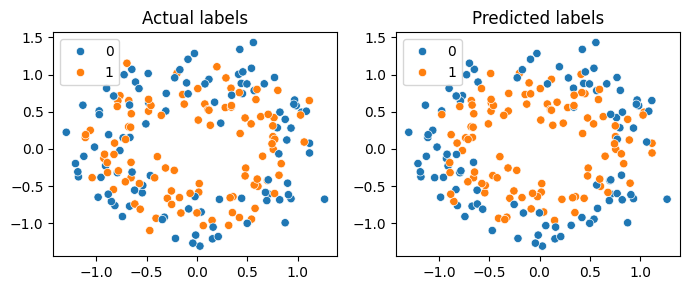

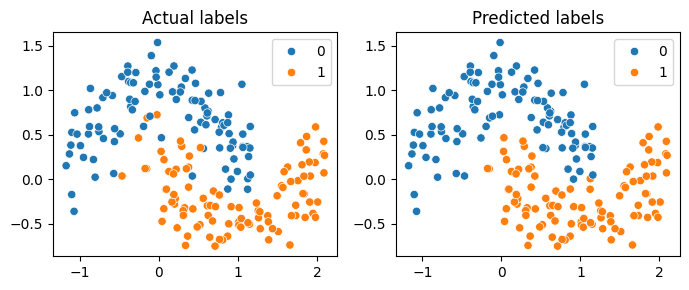

In [3]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(func):
    X, Y = func(n_samples=1000, noise=0.2, random_state=0)
    tl = int(len(X) * 0.8)
    X_train, X_test, Y_train, Y_test = X[:tl], X[tl:], Y[:tl], Y[tl:]
    clf = RandomForestClassifier(n_estimators=100, max_features="sqrt")
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    plot_data(X_test, Y_test, Y_pred)

random_forest(make_circles)
random_forest(make_moons)

## What is pruning in a decision tree algorithm?

Pruning is a technique used to prevent overfitting in decision trees. There are two main types of pruning:
- Pre-pruning: Stop growing the tree when a certain condition is met (e.g., maximum depth, minimum samples per leaf).
- Post-pruning: Grow the tree to its maximum size and then remove nodes that do not provide significant improvement in impurity measures.

## What is the difference between the bagging and boosting model?

Bagging (Bootstrap Aggregating) and boosting are ensemble learning techniques that combine multiple models to improve performance.

Bagging:
- Train multiple models independently on different bootstrap samples of the training data (sampling with replacement).
- Combine the predictions of the models through averaging or voting.
- Examples: Random Forest, Bagged Decision Trees.

Pasting: Similar to bagging, but samples are drawn without replacement.

Boosting:
- Train models sequentially, where each model corrects the errors of its predecessor.
- Weight the training instances based on their performance in previous iterations.
- Examples: AdaBoost, Gradient Boosting.

## Describe random forests and their advantages over single-decision trees.

Random forests are an ensemble learning method that combines multiple decision trees to improve performance and reduce overfitting.
Advantages of random forests over single-decision trees:
- Reduced overfitting: By aggregating the predictions of multiple trees, random forests are less prone to overfitting.
- Improved accuracy: Random forests tend to have higher accuracy than single-decision trees.
- Feature importance: Random forests can provide information on the importance of features in the classification process.
- Robustness: Random forests are robust to noise and outliers in the data.
- Parallelization: Random forests can be easily parallelized to speed up training.

# Gradient Boosting

## What is gradient boosting and how does it work?

Gradient boosting is an ensemble learning technique that builds a model in a stage-wise fashion. It combines multiple weak learners (typically decision trees) to create a strong learner. The key idea behind gradient boosting is to fit a new model to the residual errors made by the previous model.

The algorithm works as follows:
1. Fit an initial model (e.g., decision tree) to the data.
2. Calculate the residuals (errors) between the predicted values and the actual values.
3. Fit a new model to the residuals, with the goal of reducing the residuals.

This process is repeated iteratively, with each new model fitting the residuals of the previous model. The final prediction is the sum of the predictions from all models.

## What are the advantages and disadvantages of gradient boosting?

Advantages:
- High predictive accuracy: Gradient boosting often achieves high accuracy on a wide range of problems.
- Handles different types of data: Gradient boosting can handle both numerical and categorical data.
- Feature importance: Gradient boosting provides information on the importance of features in the classification process.
- Robustness: Gradient boosting is robust to noise and outliers in the data.

Disadvantages:
- Computationally expensive: Gradient boosting can be computationally expensive, especially for large datasets.
- Hyperparameter tuning: Gradient boosting requires tuning of hyperparameters to achieve optimal performance.
- Overfitting: Gradient boosting can overfit if the number of trees is too large or the learning rate is too high.

## Which are the hyperparameters in gradient boosting?

- Number of trees (n_estimators): The number of boosting stages to perform. 
- Learning rate (eta): The step size shrinkage used to prevent overfitting. This parameter scales the contribution of each tree.
- Tree depth (max_depth): The maximum depth of each tree. Deeper trees can capture more complex patterns but are more prone to overfitting.
- Minimum leaf size (min_child_weight): The minimum sum of instance weight needed in a child. The instance weight is the number of times a sample appears in the dataset.
- Row sampling (subsample): The fraction of samples used to fit each tree. This parameter can help prevent overfitting.
- Column sampling (colsample_bytree): The fraction of features used to fit each tree. This parameter can help prevent overfitting.
- L1 regularization (reg_alpha): L1 regularization term on weights. This parameter can help prevent overfitting by encouraging sparsity in the model.
- L2 regularization (reg_lambda): L2 regularization term on weights. This parameter can help prevent overfitting by penalizing large weights.
- Split improvement (gamma): The minimum loss reduction required to make a further partition on a leaf node. This parameter can help prevent overfitting by controlling the complexity of the tree.
- Leaf nodes (num_leaves): The maximum number of leaves in each tree. More leaves can make the model more complex and prone to overfitting.
- Minimum samples per leaf (min_child_samples): The minimum number of samples required to form a leaf node. This parameter can help prevent overfitting by controlling the complexity of the tree.

## What are the parameter ranges, and how do they affect the model in gradient boosting?

| Parameter Purpose | XGBoost | LightGBM | Practical Tuning Range | Effect on increasing | Effect on decreasing |
|------------------|----------|-----------|----------------------|---------------------|---------------------|
| Number of trees | `n_estimators` | `n_estimators` | [100, 2000] | More trees -> better performance, longer training time | Fewer trees -> faster training, potential underfitting |
| Learning rate | `learning_rate` (eta) | `learning_rate` | [0.01, 0.3] | Smaller learning rate -> more trees needed, better generalization | Larger learning rate -> faster training, risk of overfitting |
| Tree depth | **`max_depth`** | `max_depth` | [3, 10] | Deeper trees -> more complex model, risk of overfitting | Shallower trees -> simpler model, underfitting |
| Minimum leaf size | `min_child_weight` | `min_child_weight` | [1, 10] | Larger value -> more conservative model, less overfitting | Smaller value -> more aggressive model, risk of overfitting |
| Row sampling | `subsample` | `subsample` | [0.5, 1.0] | Lower subsample -> more robust model, longer training | Higher subsample -> potentially overfit model, faster training |
| Column sampling | `colsample_bytree` | `colsample_bytree` | [0.5, 1.0] | Lower column sampling -> more robust model | Higher column sampling -> potentially overfit model |
| L1 regularization | `reg_alpha` | `reg_alpha` | [0, 1.0] | Stronger L1 -> sparser model, more feature selection | Weaker L1 -> denser model, less feature selection |
| L2 regularization | `reg_lambda` | `reg_lambda` | [0, 5.0] | Stronger L2 -> more conservative model | Weaker L2 -> more aggressive model |
| Split improvement | `gamma` | `min_split_gain` | [0, 1.0] | Higher threshold -> more conservative splitting | Lower threshold -> more aggressive splitting |
| Leaf nodes | `max_leaves` | **`num_leaves`** | [31, 255] | More leaves -> more complex model, risk of overfitting | Fewer leaves -> simpler model, underfitting |
| Minimum samples per leaf | N/A | `min_child_samples` | [5, 30] | More samples -> more stable splits, less overfitting | Fewer samples -> more splits, risk of overfitting |

## Make a table comparing XGBoost and LightGBM.

| Feature | XGBoost | LightGBM |
|---------|---------|----------|
| Tree Growth Strategy | Level-wise, less optimal, more time-consuming | Leaf-wise, best-first, more optimized, deeper tree |
| Speed and Performance | Optimized, parallel processing, cache optimization | Faster, memory-efficient, histogram-based algorithms |
| Memory Usage | More memory consumption | More memory-efficient, histogram-based algorithms |
| Handling of Categorical Features | Latest version supports categorical features | Direct handling without encoding |
| Parallelism and GPU Support | Level-wise parallelism, GPU acceleration | Data and feature parallelism, efficient CPU utilization, GPU support |
| Overfitting Control | Regularization parameters (reg_alpha, reg_lambda) | Leaf-wise growth, num_leaves, min_data_in_leaf, regularization terms |